In [1]:
import matplotlib.pylab as plt
plt.rcParams["figure.figsize"] = [16,9]
import seaborn as sns
sns.despine()

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers import Merge
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping
from keras.optimizers import *
from keras.layers.advanced_activations import *
from keras.layers import Convolution1D, MaxPooling1D, AtrousConvolution1D
from keras.layers.recurrent import LSTM, GRU
from keras import regularizers
from keras.utils import plot_model
from sklearn.metrics import roc_curve, auc

import theano
theano.config.compute_test_value = "ignore"

import pandas as pd
import numpy as np


Using TensorFlow backend.


In [2]:
def shuffle_in_unison(a, b):
    # https://stackoverflow.com/questions/4601373/better-way-to-shuffle-two-numpy-arrays-in-unison
    assert len(a) == len(b)
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b
 
def create_Xt_Yt(X, y, percentage=0.9):
    p = int(len(X) * percentage)
    X_train = X[0:p]
    Y_train = y[0:p]
     
    X_train, Y_train = shuffle_in_unison(X_train, Y_train)
 
    X_test = X[p:]
    Y_test = y[p:]

    return X_train, X_test, Y_train, Y_test

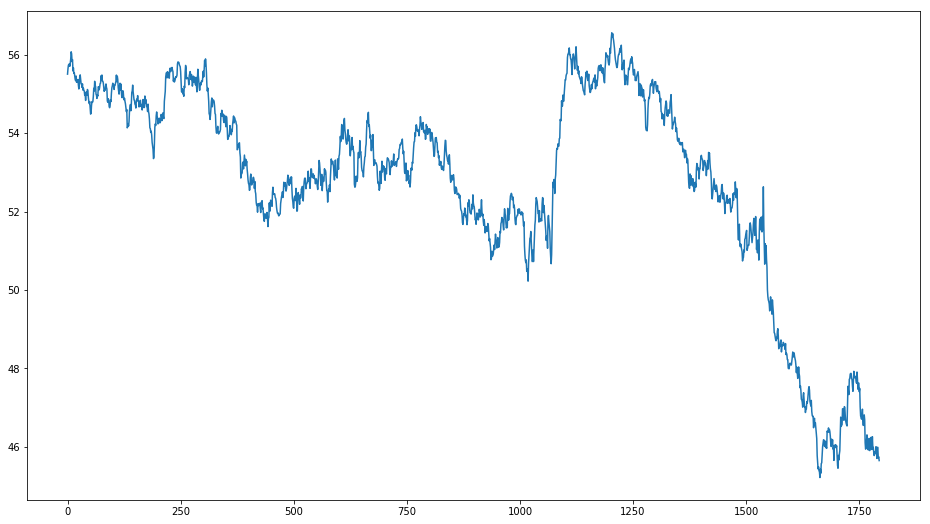

list index out of range


In [52]:
data = pd.read_csv('stockdatas/SCHP.csv')[::-1]
data = data.loc[:, 'adjClose'].tolist()

# Uncomment below to use price instead time series
# data = data.loc[:, 'adjClose'].pct_change().dropna().tolist()

plt.plot(data)
plt.show()

WINDOW = 120
EMB_SIZE = 1
STEP = 1
FORECAST = 20

# Straightforward way for creating time windows
X, Y = [], []
for i in range(0, len(data), STEP): 
    try:
        x_i = data[i:i+WINDOW]
        y_i = data[i+WINDOW+FORECAST]  

        last_close = x_i[WINDOW-1]
        next_close = y_i

        if last_close < next_close:
            y_i = [1, 0]
        else:
            y_i = [0, 1] 

    except Exception as e:
        print(e)
        break

    X.append(x_i)
    Y.append(y_i)

X = [(np.array(x) - np.mean(x)) / np.std(x) for x in X] # comment it to remove normalization
X, Y = np.array(X), np.array(Y)

X_train, X_test, Y_train, Y_test = create_Xt_Yt(X, Y)

In [53]:
# https://keras.io/optimizers/
# https://keras.io/activations/

model = Sequential()

model.add(Dense(64, input_dim=120,
                activity_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(LeakyReLU())

model.add(Dropout(0.5))

model.add(Dense(16,
                activity_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(LeakyReLU())

model.add(Dense(2))
model.add(Activation('linear'))

opt = Adam(lr=0.001)

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.9, patience=25, min_lr=0.000001, verbose=1)
checkpointer = ModelCheckpoint(filepath="test.hdf5", verbose=1, save_best_only=True)
model.compile(optimizer=opt, 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [54]:
history = model.fit(X_train, Y_train, 
          epochs = 25, 
          batch_size = 2, 
          verbose=2, 
          validation_data=(X_test, Y_test),
          callbacks=[reduce_lr, checkpointer],
          shuffle=True)



Train on 1489 samples, validate on 166 samples
Epoch 1/25
Epoch 00000: val_loss improved from inf to 4.33261, saving model to test.hdf5
3s - loss: 3.9377 - acc: 0.4896 - val_loss: 4.3326 - val_acc: 0.5422
Epoch 2/25
Epoch 00001: val_loss improved from 4.33261 to 3.22946, saving model to test.hdf5
2s - loss: 3.6508 - acc: 0.4560 - val_loss: 3.2295 - val_acc: 0.5181
Epoch 3/25
Epoch 00002: val_loss did not improve
2s - loss: 3.6981 - acc: 0.4661 - val_loss: 4.4284 - val_acc: 0.5602
Epoch 4/25
Epoch 00003: val_loss improved from 3.22946 to 2.18478, saving model to test.hdf5
2s - loss: 3.4042 - acc: 0.4574 - val_loss: 2.1848 - val_acc: 0.4277
Epoch 5/25
Epoch 00004: val_loss did not improve
2s - loss: 3.3815 - acc: 0.4466 - val_loss: 2.9574 - val_acc: 0.5663
Epoch 6/25
Epoch 00005: val_loss did not improve
2s - loss: 3.5654 - acc: 0.4171 - val_loss: 2.6685 - val_acc: 0.5361
Epoch 7/25
Epoch 00006: val_loss did not improve
2s - loss: 3.0652 - acc: 0.4433 - val_loss: 3.3507 - val_acc: 0.5241

In [55]:
scores = model.evaluate(X_test, Y_test, verbose=1)
print("\nModel Accuracy: %.2f%%" % (scores[1]*100))

 32/166 [====>.........................] - ETA: 0s
Model Accuracy: 39.16%


In [56]:
plot_model(model, to_file='model.png', show_shapes=False, show_layer_names=True, rankdir='TB')

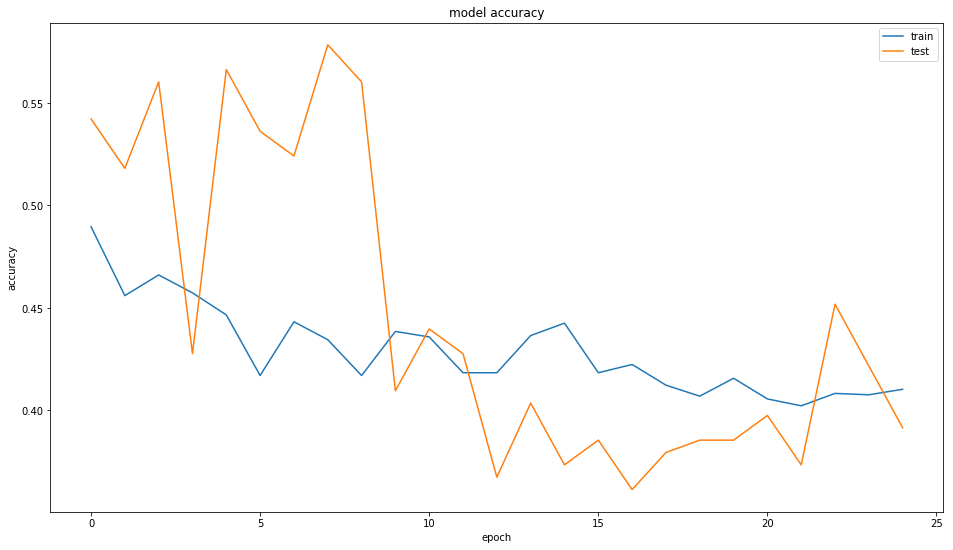

In [57]:
plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

Predicting on test data
Generating results


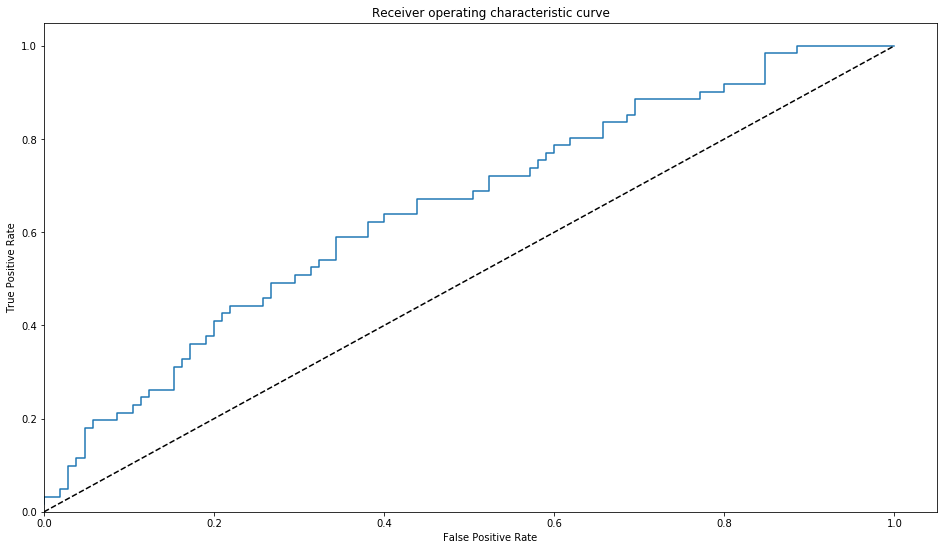

AUC: 0.650117


In [58]:
def generate_results(y_test, y_score):
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.05])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic curve')
    plt.show()
    print('AUC: %f' % roc_auc)
    
print('Predicting on test data')
y_score = model.predict(X_test)

print('Generating results')
generate_results(Y_test[:, 0], y_score[:, 0])